# Overview

The objective of this project is to understand and predict the emotion of people from facial images. We will build a system to identify the key facial points in an image as well as predict the emotion in that image. 


Source: https://www.kaggle.com/competitions/facial-keypoints-detection/data

Source: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
import random
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# FACIAL KEY-POINT DETECTION

## Data Inspection and Exploration

In [2]:
df = pd.read_csv('data/data.csv')

In [3]:
df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [5]:
df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


The data contains the x-y coordinates of various key facial points. We will get a better understanding of these coordinates once we plot them. However, before that we need to convert the Image column to a numpy array in order to represent the pixel values of an image

In [6]:
# Checking for the number of pixel values in one image
len(df.Image[0].split(' '))

9216

In [7]:
np.fromstring(df.Image[0], sep=' ')

array([238., 236., 237., ...,  70.,  75.,  90.])

In [8]:
# Converting the Image column to numpy array and respahing it to (96,96)

df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' ').reshape(96,96))

In [9]:
df.Image[0].shape

(96, 96)

We have converted the Image column to represent images with (96,96) shape

## Image Visualization

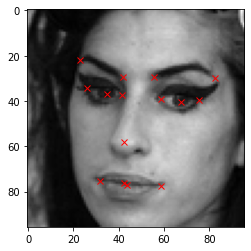

In [10]:
i = np.random.randint(1, len(df))

plt.imshow(df.Image[i], cmap='gray')
for j in range(1,31,2):
    plt.plot(df.iloc[i][j-1],df.iloc[i][j], 'rx')

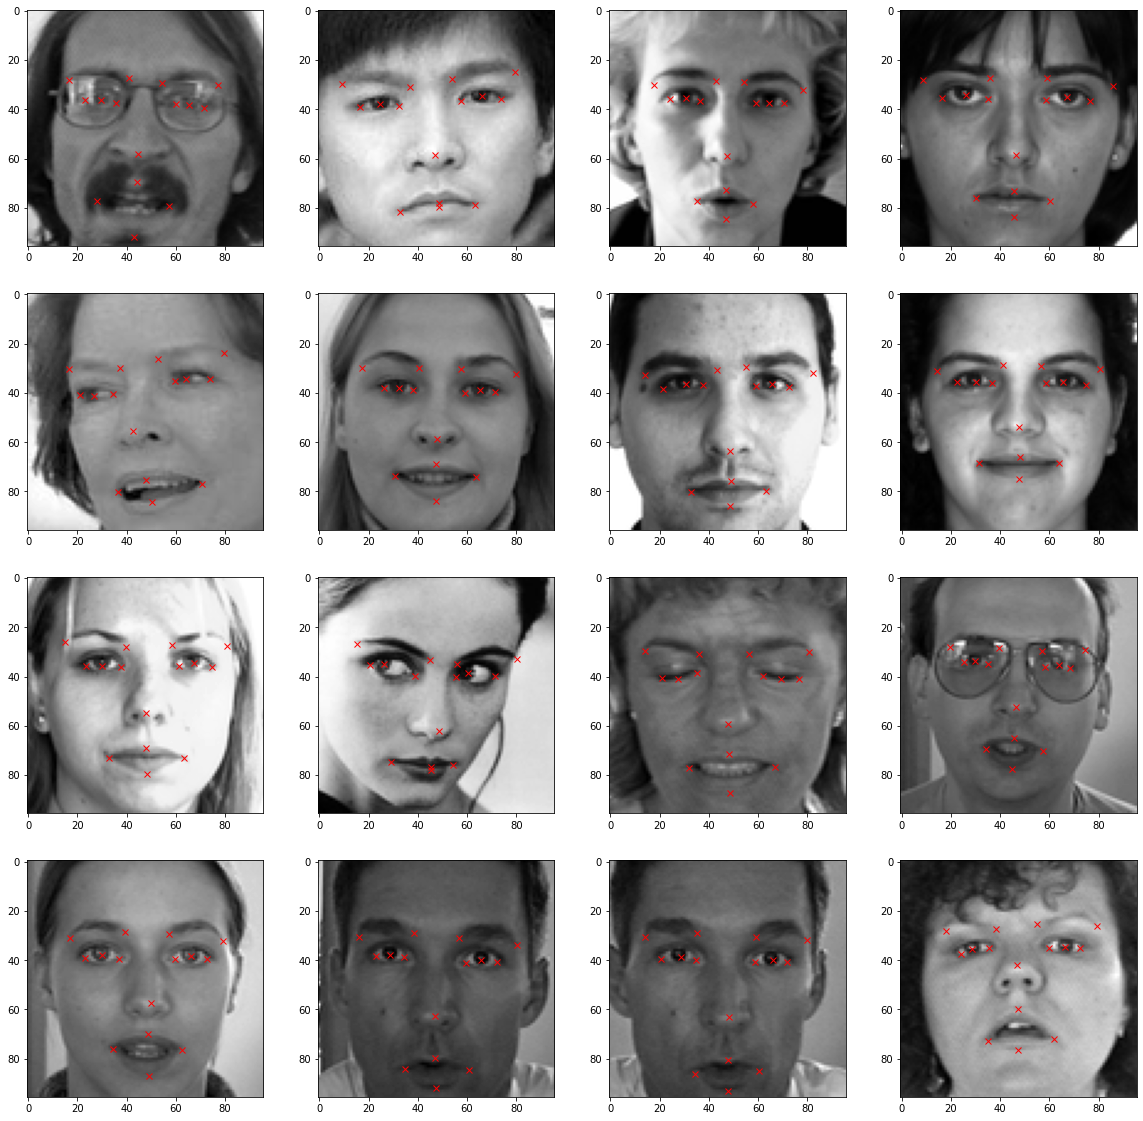

In [11]:
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for j in range(16):
    i = random.randint(1,len(df))
    ax = fig.add_subplot(4, 4, j + 1)    
    image = plt.imshow(df['Image'][i],cmap='gray')
    for j in range(1,31,2):
        plt.plot(df.iloc[i][j-1], df.iloc[i][j], 'rx')

## Data Augmentation

We will perform horizontal flip and increase the brightness of the images to perform image augmentation

In [12]:
# Creating a copy of the df

df_copy = df.copy()

In [13]:
# List of columns containing the x and y coordinates of the key points

cols = df_copy.columns[:-1]
cols

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [14]:
# Horizontal flip

df_copy['Image'] = df_copy['Image'].apply(lambda x: np.flip(x, axis=1))

Since we are flipping the image horizantally, the y coordinates will be the same as original. Only x coordiante values would change. We will subtract our initial x-coordinate values from 96 (width of the image)

In [15]:
for i in range(len(cols)):
    if i%2==0:
        df_copy[cols[i]] = df_copy[cols[i]].apply(lambda x: 96. - x )

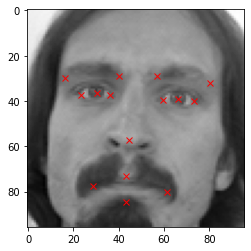

In [16]:
#Original image
plt.imshow(df['Image'][0],cmap='gray')
for j in range(1,31,2):
        plt.plot(df.iloc[0][j-1], df.iloc[0][j], 'rx')

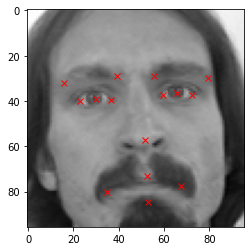

In [17]:
# Horizontally flipped image
plt.imshow(df_copy['Image'][0],cmap='gray')
for j in range(1,31,2):
        plt.plot(df_copy.iloc[0][j-1], df_copy.iloc[0][j], 'rx')

In [18]:
# Concatenating original dataframe with the augmneted dataframe
augmented_df = pd.concat([df,df_copy])
augmented_df.shape

(4280, 31)

We will randomly increase the brightness by multipling pixel values by random values between 1 and 2. However, we also must make sure that no pixel value becomes greater than 255. So we will clip the values between 0 and 255.

Following a similar process, we will also decrease the brightness by multiplyting the pixel values with random values between 0 and 1

In [19]:
import random

# Increasing brightness

df_copy = df.copy()
df_copy['Image'] = df['Image'].apply(lambda x:np.clip(random.uniform(1, 2)* x,0.0, 255.0))
augmented_df = pd.concat([augmented_df,df_copy])
augmented_df.shape

(6420, 31)

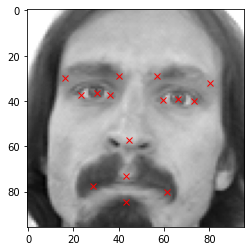

In [20]:
# Image with increased brightness

plt.imshow(df_copy['Image'][0],cmap='gray')
for j in range(1,31,2):
        plt.plot(df_copy.iloc[0][j-1], df_copy.iloc[0][j], 'rx')

In [21]:
# Decreasing brightness

df_copy = df.copy()
df_copy['Image'] = df['Image'].apply(lambda x:np.clip(random.uniform(0, 1)* x,0.0, 255.0))
augmented_df = pd.concat([augmented_df,df_copy])
augmented_df.shape

(8560, 31)

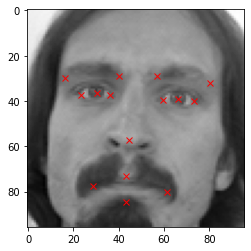

In [22]:
#Brightness decreased image

plt.imshow(df_copy['Image'][0],cmap='gray')
for j in range(1,31,2):
        plt.plot(df_copy.iloc[0][j-1], df_copy.iloc[0][j], 'rx')

In [23]:
# Reset the index for the augmented data frame
augmented_df.reset_index(drop=True, inplace=True)

## Data Normalization and Train Test Split

In [24]:
#Gettin the value of images
img = augmented_df['Image']

#Normalizig the image
img = img/255.

#Creating an empty array of shape (8560,96,96,1) to feed to the model
X = np.empty((len(img), 96, 96, 1))

#Iterating through the img list and adding image values to the empty array after expanding it's dimension 
#from (96,96) to (96,96,1)

for i in range(len(img)):
    X[i,]= np.expand_dims(img[i], axis = 2)

In [29]:
X.shape

(8560, 96, 96, 1)

In [33]:
# Getting the value of coordinates which is the target variable 
y = augmented_df.drop('Image', axis=1)
y.shape

(8560, 30)

In [35]:
#Splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

## Build Deep Residual Neural Network

In [36]:
def res_block(X, filter, stage):
    #Convolutional_block
    
    X_copy = X

    f1 , f2, f3 = filter
    #Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


    #Short path

    X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

    #ADD

    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    #Identity Block 1

    X_copy = X


      #Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

    #ADD

    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    #Identity Block 2

    X_copy = X


      #Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

    #ADD

    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [37]:
input_shape = (96,96,1)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)



#Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

#Final layer

X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model( inputs= X_input, outputs = X)
model.summary()

Metal device set to: Apple M1


2022-06-07 22:05:36.453904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-07 22:05:36.454779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 18,016,286
Trainable params: 18,007,710
Non-trainable params: 8,576
__________________________________________________________________________________________________


## Compile and Train the Model

In [38]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error",optimizer= adam , metrics = ['accuracy'])

ValueError: Could not interpret optimizer identifier: <keras.optimizer_v2.adam.Adam object at 0x16b6b3a00>

In [39]:
#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights_keypoint.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size = 32, epochs= 500, validation_split = 0.05, callbacks=[checkpointer])

In [ ]:
#saving the model architecture to json file for future use

model_json = model.to_json()
with open("detection.json","w") as json_file:
    json_file.write(model_json)

In [ ]:
with open('detection.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights_keypoint.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error",optimizer= adam , metrics = ['accuracy'])

## Model Evaluation

In [ ]:
#Evaluating the model

result = model.evaluate(X_test,y_test)
print("Accuracy : {}".format(result[1]))

In [ ]:
#plotting the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()